In [ ]:
import torch
from google.colab import drive

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
drive.mount('/content/drive')

Using device: cuda
Mounted at /content/drive


# Load Dataset

In [ ]:
import kagglehub

path = kagglehub.dataset_download("gonzalorecioc/color-polygon-images")
print("Path to dataset files:", path)

100%|██████████| 8.00M/8.00M [00:00<00:00, 98.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gonzalorecioc/color-polygon-images/versions/1


In [ ]:
import os
import pandas as pd

csv_path = os.path.join(path, "targets.csv")
df = pd.read_csv(csv_path)
df.head()

,Unnamed: 0,filename,sides,bg_color,fg_color,bound_circle_x,bound_circle_y,bound_circle_r,rotation
0,0,70aaa621-1345-4541-a954-ee9856daaf18.png,4,blue,pink,29,39,15,185
1,1,ea0d8d14-596a-4365-b007-6325fc96e0f4.png,3,black,yellow,66,66,21,215
2,2,48c1fc5a-8b6b-4555-bb6a-a7d42a5cedc2.png,4,yellow,red,59,103,20,59
3,3,ad721906-604c-4682-ae5d-15539ef1dbc7.png,3,green,pink,65,66,61,272
4,4,510dd5ea-fb92-432e-91cc-ed4654a03ebd.png,6,white,green,48,56,42,38


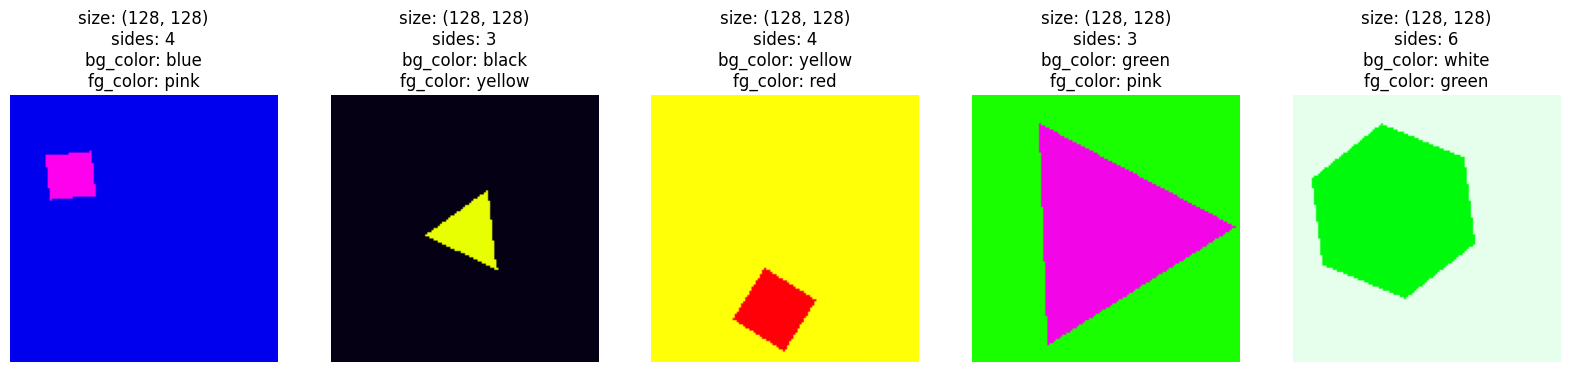

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

images_dir = os.path.join(path, "images", "content", "images")
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in enumerate(axes):
  row = df.iloc[i]
  full_image_path = os.path.join(images_dir, row['filename'])
  img = mpimg.imread(full_image_path)

  ax.imshow(img)
  ax.set_title(
    f"size: {img.shape[:2]}\n"
    f"sides: {row['sides']}\n"
    f"bg_color: {row['bg_color']}\n"
    f"fg_color: {row['fg_color']}"
  )
  ax.axis('off')

plt.show()

In [ ]:
side_counts = df['sides'].value_counts().sort_index()
side_counts.to_frame().T

sides,3,4,5,6
count,2497,2532,2437,2534


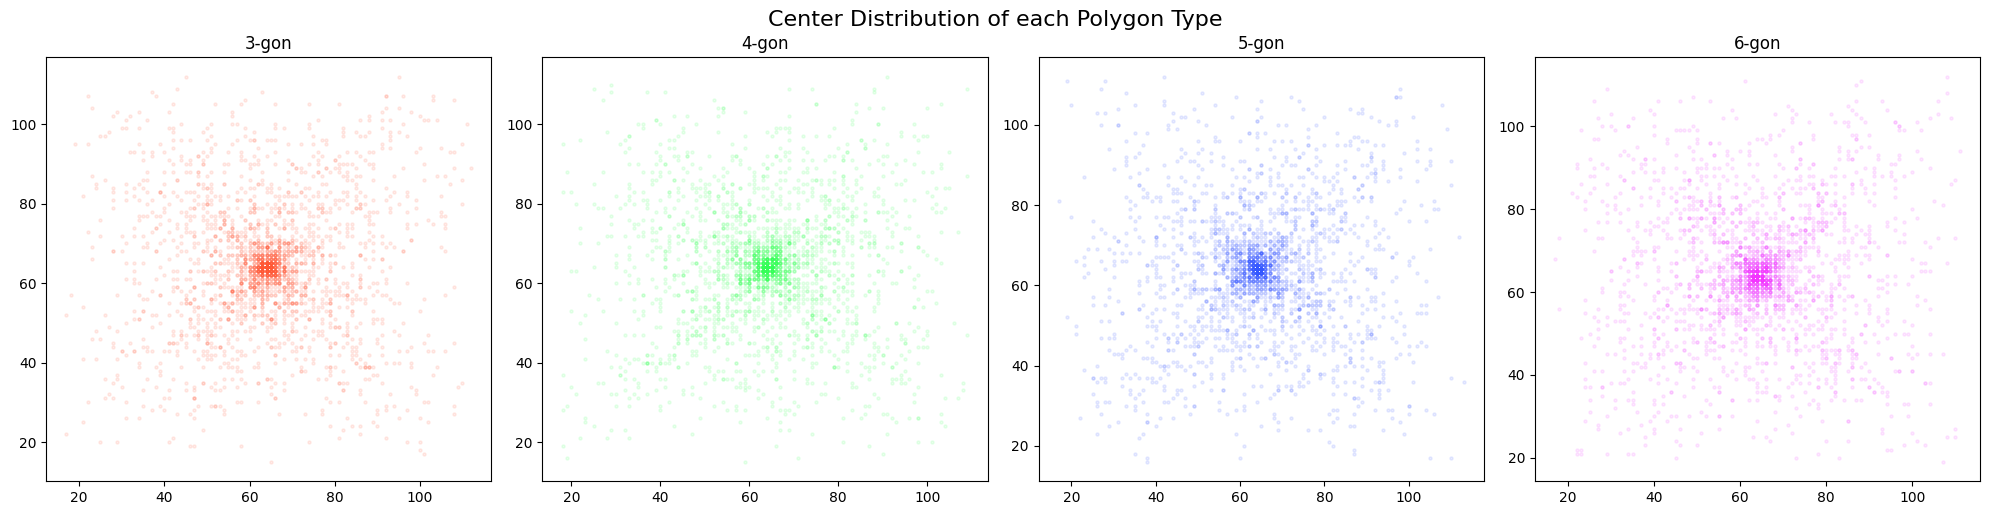

In [ ]:
sides = [3, 4, 5, 6]
colors = ['#FF5733', '#33FF57', '#3357FF', '#F333FF']
fig, axes = plt.subplots(1, len(sides), figsize=(20, 5))
for ax, side, color in zip(axes, sides, colors):
  subset = df[df['sides'] == side]
  ax.scatter(
    subset['bound_circle_x'],
    subset['bound_circle_y'],
    alpha=0.1,
    s=5,
    color=color,
  )
  ax.set_title(f"{side}-gon")

plt.tight_layout()
plt.suptitle("Center Distribution of each Polygon Type", fontsize=16, y=1.02)
plt.show()

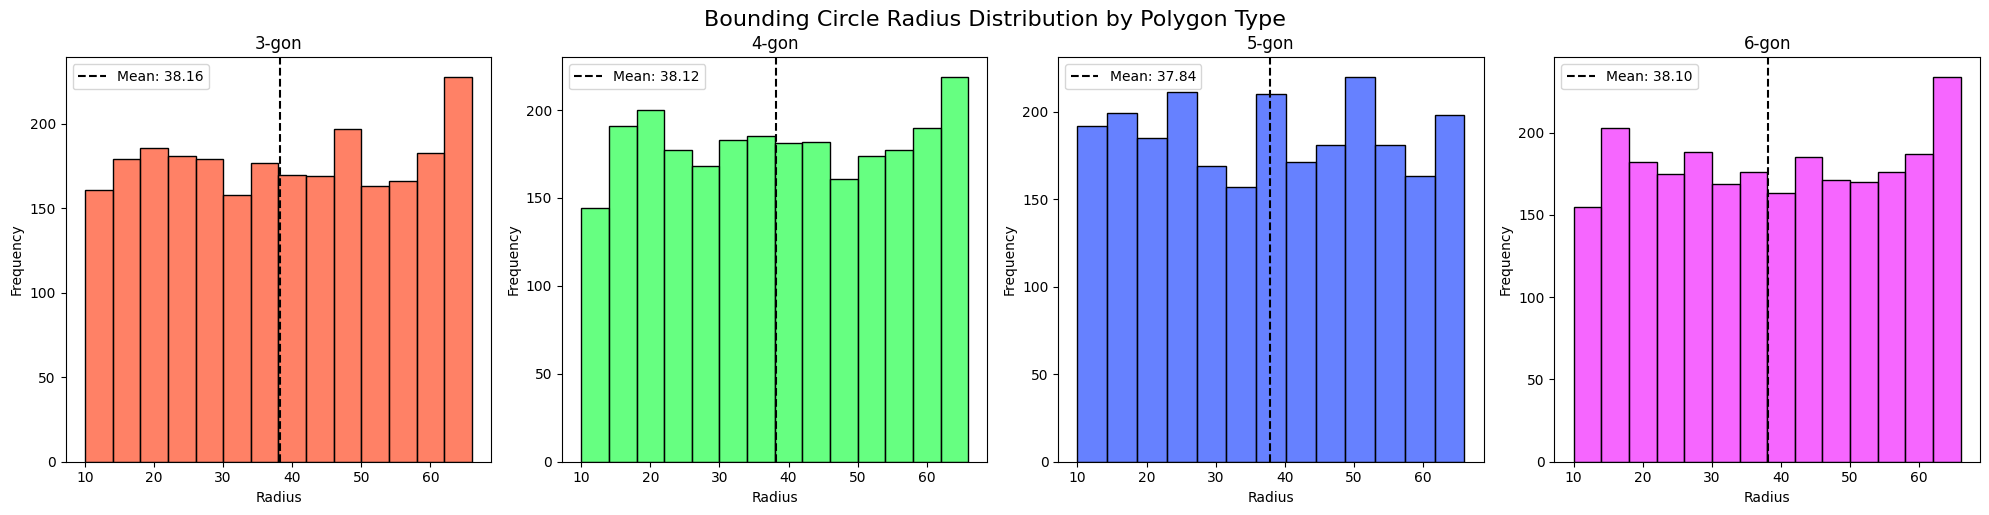

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(1, len(sides), figsize=(20, 5))
for ax, side, color in zip(axes, sides, colors):
  subset = df[df['sides'] == side]
  sns.histplot(subset['bound_circle_r'], ax=ax, color=color)

  mean_r = subset['bound_circle_r'].mean()
  ax.axvline(mean_r, color='black', linestyle='--', label=f'Mean: {mean_r:.2f}')

  ax.set_title(f"{side}-gon")
  ax.set_xlabel("Radius")
  ax.set_ylabel("Frequency")
  ax.legend()

plt.tight_layout()
plt.suptitle("Bounding Circle Radius Distribution by Polygon Type", fontsize=16, y=1.02)
plt.show()

In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

class PolygonDataset(Dataset):
  def __init__(self, df, img_dir, transform=None):
    self.df = df
    self.img_dir = img_dir
    self.transform = transform

    self.classes = sorted(self.df['sides'].unique())
    self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

  def __len__(self): return len(self.df)

  def __getitem__(self, idx):
    img_name = self.df.loc[idx, 'filename']
    img_path = os.path.join(self.img_dir, img_name)
    image = Image.open(img_path)

    label_text = self.df.loc[idx, 'sides']
    label = self.class_to_idx[label_text]

    if self.transform: image = self.transform(image)
    return image, label

transform = transforms.Compose([transforms.ToTensor()])
dataset = PolygonDataset(df, images_dir, transform)

total_count = len(dataset)
train_count = int(0.8 * total_count)
test_count = total_count - train_count
train_dataset, test_dataset = random_split(dataset, [train_count, test_count])

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

x_sample, y_sample = next(iter(train_loader))
print(f"Batch Shape: {tuple(x_sample.shape)}")
print(f"Label Shape: {tuple(y_sample.shape)}")

Batch Shape: (32, 3, 128, 128)
Label Shape: (32,)


# The NN

In [ ]:
import torch.nn as nn

model = nn.Sequential(
  nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
  nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
  nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
  nn.Flatten(),
  nn.Linear(64 * 16 * 16, 128), nn.ReLU(),
  nn.Dropout(0.25),
  nn.Linear(128, 4)
).to(device)
print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=16384, out_features=128, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.25, inplace=False)
  (13): Linear(in_features=128, out_features=4, bias=True)
)


Epoch 1/100, Loss: 1.3416, Accuracy: 31.95%
Epoch 2/100, Loss: 1.0986, Accuracy: 48.33%
Epoch 3/100, Loss: 0.8763, Accuracy: 60.70%
Epoch 4/100, Loss: 0.7310, Accuracy: 67.61%
Epoch 5/100, Loss: 0.6147, Accuracy: 73.78%
Epoch 6/100, Loss: 0.5340, Accuracy: 77.05%
Epoch 7/100, Loss: 0.4732, Accuracy: 79.46%
Epoch 8/100, Loss: 0.4125, Accuracy: 82.86%
Epoch 9/100, Loss: 0.3707, Accuracy: 84.21%
Epoch 10/100, Loss: 0.3494, Accuracy: 85.71%
Epoch 11/100, Loss: 0.3097, Accuracy: 87.33%
Epoch 12/100, Loss: 0.2865, Accuracy: 88.50%
Epoch 13/100, Loss: 0.2539, Accuracy: 89.94%
Epoch 14/100, Loss: 0.2558, Accuracy: 90.12%
Epoch 15/100, Loss: 0.2244, Accuracy: 90.84%
Epoch 16/100, Loss: 0.2233, Accuracy: 91.20%
Epoch 17/100, Loss: 0.2139, Accuracy: 91.70%
Epoch 18/100, Loss: 0.1975, Accuracy: 92.41%
Epoch 19/100, Loss: 0.1856, Accuracy: 92.88%
Epoch 20/100, Loss: 0.1685, Accuracy: 93.46%
Epoch 21/100, Loss: 0.1620, Accuracy: 93.67%
Epoch 22/100, Loss: 0.1648, Accuracy: 93.88%
Epoch 23/100, Loss:

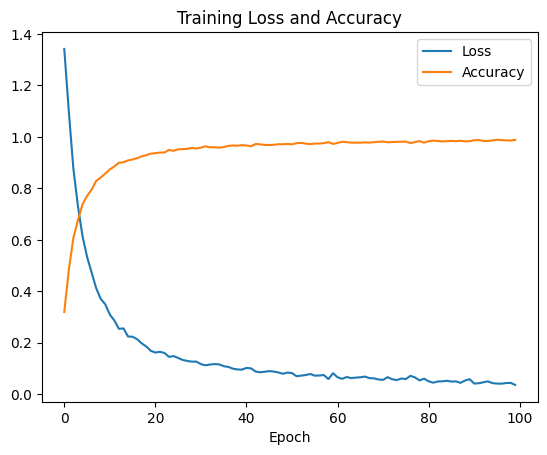

In [ ]:
import torch.optim as optim
import time


EPOCHS = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_history = []
acc_history = []

model.train()
start_time = time.time()
for epoch in range(EPOCHS):
  running_loss = 0.0
  correct = 0
  total = 0

  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  epoch_acc = correct / total
  epoch_loss = running_loss / len(train_loader)
  loss_history.append(epoch_loss)
  acc_history.append(epoch_acc)
  print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc*100:.2f}%")
  if epoch_loss < 0.001: break

if device.type == 'cuda': torch.cuda.synchronize()
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

plt.plot(loss_history, label='Loss')
plt.plot(acc_history, label='Accuracy')
plt.xlabel('Epoch')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()

In [ ]:
import numpy as np


model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)

    probs = nn.functional.softmax(outputs, dim=1)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    all_probs.extend(probs.cpu().numpy())

print(f"Test Accuracy: {correct / total * 100:.2f}%")
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

Test Accuracy: 85.80%


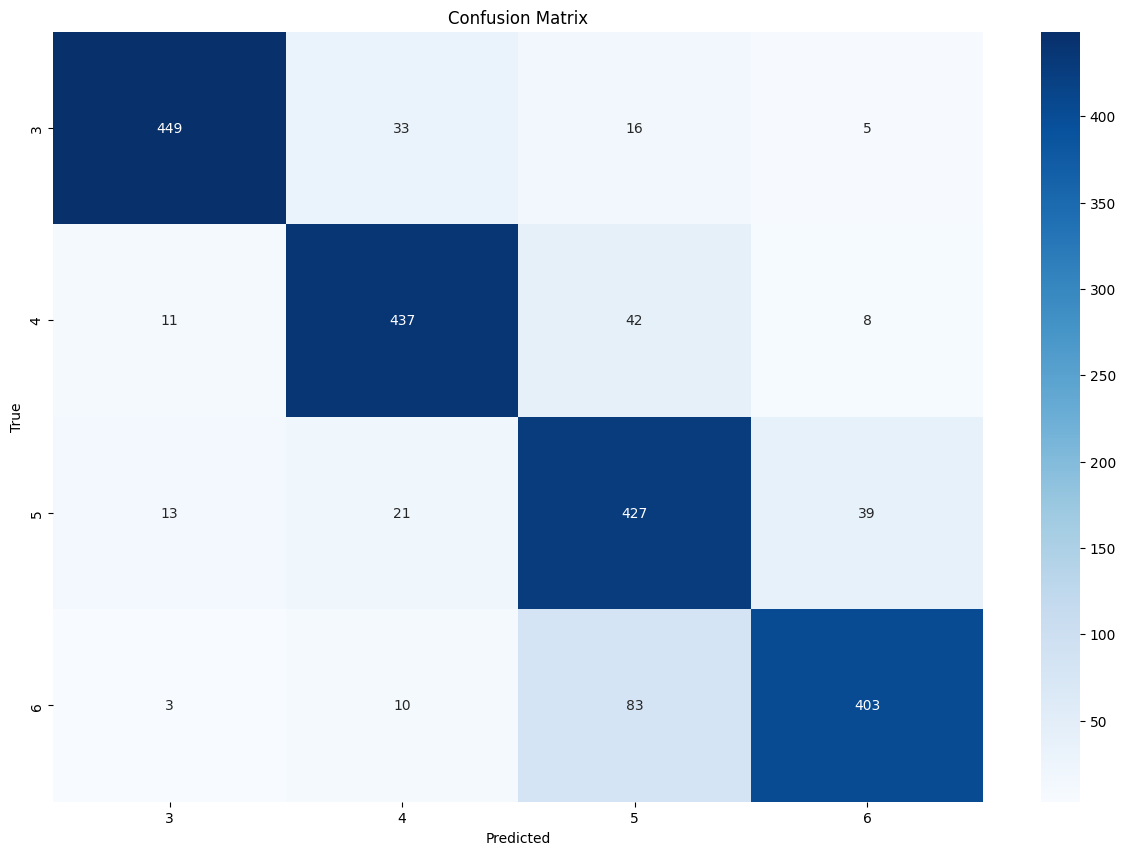

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mat = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(15, 10))
classes = [3, 4, 5, 6]
ax = sns.heatmap(confusion_mat, annot=True, fmt='d', ax=ax, cmap="Blues", xticklabels=classes, yticklabels=classes)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

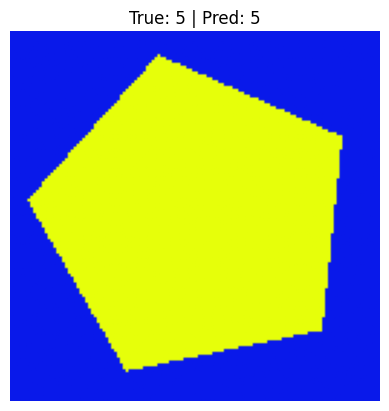

In [ ]:
indices = np.random.choice(len(test_dataset))
x_sample_img, y_sample_true = test_dataset[indices]
y_sample_pred = all_preds[indices]

plt.title(f"True: {y_sample_true+3} | Pred: {y_sample_pred+3}")
plt.imshow(x_sample_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

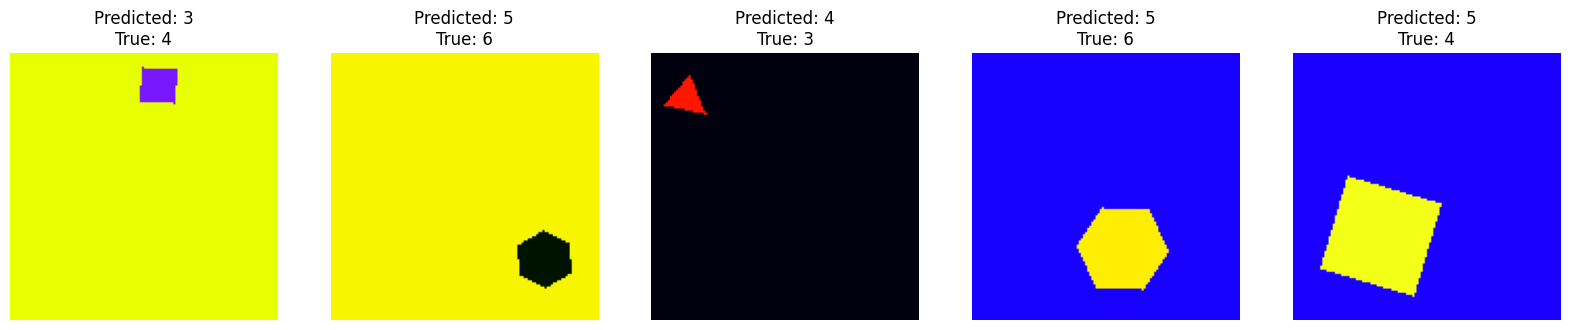

In [ ]:
errors = (all_preds != all_labels)
error_preds = all_preds[errors]
error_probs = all_probs[errors]
error_labels = all_labels[errors]
error_samples = [test_dataset[i][0] for i in np.where(errors)[0]]

error_pred_probs = np.max(error_probs, axis=1)
error_label_probs = np.diagonal(np.take(error_probs, error_labels, axis=1))
diffs = error_pred_probs - error_label_probs
top_indices = np.argsort(diffs)[-5:]

fig, axes = plt.subplots(1, len(top_indices), figsize=(20, 20))
for idx, ax in zip(top_indices, axes):
  ax.imshow(error_samples[idx].permute(1, 2, 0))
  ax.set_title(f"Predicted: {error_preds[idx]+3}\nTrue: {error_labels[idx]+3}")
  ax.axis('off')
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Polygon_Model.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Polygon_Model.pth', map_location=device))
model.eval()

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=16384, out_features=128, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.25, inplace=False)
  (13): Linear(in_features=128, out_features=4, bias=True)
)

In [ ]:
import cv2


class GradCAM:
  def save_feature_maps(self, module, input, output): self.feature_maps = output
  def save_gradients(self, module, grad_input, grad_output): self.gradients = grad_output[0]

  def __init__(self):
    self.feature_maps = None
    self.gradients = None
    last_conv = model[6]
    last_conv.register_forward_hook(self.save_feature_maps)
    last_conv.register_full_backward_hook(self.save_gradients)

  def generate_cam(self, input_tensor):
    output = model(input_tensor)
    target_class = output.argmax(dim=1).item()

    model.zero_grad()
    target = output[0][target_class]
    target.backward()

    gradients = self.gradients[0]
    activations = self.feature_maps[0]
    weights = torch.mean(gradients, dim=(1, 2))
    cam = (weights[:, None, None] * activations).sum(dim=0)
    cam = torch.relu(cam)

    cam = cam.cpu().detach().numpy()
    cam = cv2.resize(cam, (128, 128))
    cam = cv2.normalize(cam, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return cam

grad_cam = GradCAM()

In [ ]:
import base64
from io import BytesIO
from IPython.display import HTML, display, JSON
from google.colab import output
from PIL import Image

canvas_html = """
<style>
  .canvas-container {
    display: flex;
    flex-direction: column;
    align-items: center;
    font-family: 'Segoe UI', sans-serif;
    background: #f0f2f5;
    padding: 20px;
    border-radius: 15px;
    box-shadow: 0 4px 15px rgba(0,0,0,0.1);
    color: #333;
    max-width: 600px;
    margin: 0 auto;
  }
  .canvas-wrapper {
    display: flex;
    gap: 20px;
    margin: 15px 0;
    align-items: center;
    justify-content: center;
  }
  .view-box {
    display: flex;
    flex-direction: column;
    align-items: center;
  }
  .view-label {
    margin-bottom: 5px;
    font-size: 14px;
    font-weight: bold;
    color: #555;
  }
  canvas, #camImage {
    border: 3px solid #444;
    background-color: black;
    image-rendering: pixelated;
    display: block;
    width: 200px;
    height: 200px;
  }
  .config-panel {
    display: flex;
    gap: 20px;
    margin-bottom: 15px;
    background: white;
    padding: 10px 20px;
    border-radius: 10px;
  }
  .color-item {
    display: flex;
    flex-direction: column;
    align-items: center;
    gap: 5px;
  }
  label { font-size: 12px; font-weight: bold; color: #666; }
  .controls { display: flex; gap: 10px; }
  button {
    padding: 10px 25px;
    font-weight: bold;
    cursor: pointer;
    border: none;
    border-radius: 8px;
    transition: transform 0.1s;
  }
  button:active { transform: scale(0.95); }
  .btn-predict { background-color: #007bff; color: white; }
  .btn-clear { background-color: #6c757d; color: white; }

  #info-text { font-size: 13px; color: #777; margin-bottom: 5px; }
  #result-display {
    margin-top: 20px;
    font-size: 22px;
    font-weight: bold;
    color: #007bff;
    min-height: 30px;
  }
</style>

<div class="canvas-container">
  <div class="config-panel">
    <div class="color-item">
      <label>Background</label>
      <input type="color" id="bgColor" value="#000000" onchange="updateColors()">
    </div>
    <div class="color-item">
      <label>Polygon</label>
      <input type="color" id="fgColor" value="#ffffff" onchange="updateColors()">
    </div>
  </div>

  <div id="info-text">Left Click: Add Vertex | Right Click: Render & Fill</div>

  <div class="canvas-wrapper">
    <div class="view-box">
      <div class="view-label">Input</div>
      <canvas id="polyCanvas" width="128" height="128"></canvas>
    </div>
    <div class="view-box">
      <div class="view-label">Grad-CAM Explanation</div>
      <img id="camImage" src="data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///yH5BAEAAAAALAAAAAABAAEAAAIBRAA7" />
    </div>
  </div>

  <div class="controls">
    <button class="btn-clear" onclick="clearCanvas()">Clear</button>
    <button class="btn-predict" onclick="sendToModel()">Predict Shape</button>
  </div>

  <div id="result-display">Ready</div>
</div>

<script>
  const canvas = document.getElementById('polyCanvas');
  const camImg = document.getElementById('camImage');
  const ctx = canvas.getContext('2d');
  const resultDiv = document.getElementById('result-display');
  const bgColorInput = document.getElementById('bgColor');
  const fgColorInput = document.getElementById('fgColor');

  let vertices = [];
  let isFinished = false;

  function initCanvas() {
    ctx.fillStyle = bgColorInput.value;
    ctx.fillRect(0, 0, canvas.width, canvas.height);
    vertices = [];
    isFinished = false;
    resultDiv.innerText = "Ready";
    camImg.src = "data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///yH5BAEAAAAALAAAAAABAAEAAAIBRAA7";
  }

  function updateColors() {
    if (vertices.length > 0) {
        isFinished ? renderFinal() : renderCurrent();
    } else {
        initCanvas();
    }
  }

  canvas.addEventListener('mousedown', (e) => {
    if (isFinished) return;
    if (e.button === 0) {
        const rect = canvas.getBoundingClientRect();
        const x = (e.clientX - rect.left) * (canvas.width / rect.width);
        const y = (e.clientY - rect.top) * (canvas.height / rect.height);
        vertices.push({x, y});
        renderCurrent();
    }
  });

  canvas.addEventListener('contextmenu', (e) => {
    e.preventDefault();
    if (vertices.length < 3) return;
    isFinished = true;
    renderFinal();
  });

  function renderCurrent() {
    ctx.fillStyle = bgColorInput.value;
    ctx.fillRect(0, 0, canvas.width, canvas.height);
    if (vertices.length === 0) return;

    ctx.beginPath();
    ctx.strokeStyle = fgColorInput.value;
    ctx.lineWidth = 1;
    ctx.moveTo(vertices[0].x, vertices[0].y);
    for (let i = 1; i < vertices.length; i++) {
      ctx.lineTo(vertices[i].x, vertices[i].y);
    }
    ctx.stroke();

    ctx.fillStyle = "#ffcc00";
    vertices.forEach(v => {
      ctx.beginPath();
      ctx.arc(v.x, v.y, 2, 0, Math.PI * 2);
      ctx.fill();
    });
  }

  function renderFinal() {
    ctx.fillStyle = bgColorInput.value;
    ctx.fillRect(0, 0, canvas.width, canvas.height);
    ctx.beginPath();
    ctx.moveTo(vertices[0].x, vertices[0].y);
    for (let i = 1; i < vertices.length; i++) {
      ctx.lineTo(vertices[i].x, vertices[i].y);
    }
    ctx.closePath();
    ctx.fillStyle = fgColorInput.value;
    ctx.fill();
    resultDiv.innerText = "Polygon Rendered";
  }

  function clearCanvas() {
    initCanvas();
  }

  async function sendToModel() {
    if (vertices.length < 3) {
        resultDiv.innerText = "Need 3+ points!";
        return;
    }
    if (!isFinished) renderFinal();

    const dataUrl = canvas.toDataURL('image/png');
    const base64Data = dataUrl.split(',')[1];

    resultDiv.innerText = "Analyzing...";
    try {
        const result = await google.colab.kernel.invokeFunction('notebook.PredictPolygon', [base64Data], {});

        // Ensure we read the correct MIME type
        const data = result.data['application/json'];

        if (data) {
            resultDiv.innerText = data.text;
            camImg.src = "data:image/png;base64," + data.image;
        } else {
             // Fallback for debugging
             console.log("Full Result:", result);
             resultDiv.innerText = "Error: Invalid response format";
        }

    } catch (e) {
        resultDiv.innerText = "Error: " + e;
        console.error(e);
    }
  }
  initCanvas();
</script>
"""

def predict_polygon(base64_image):
  image_data = base64.b64decode(base64_image)
  img = Image.open(BytesIO(image_data)).convert('RGB')
  img = img.resize((128, 128))

  transform = transforms.Compose([transforms.ToTensor()])
  img_tensor = transform(img).unsqueeze(0).to(device)

  cam_map = grad_cam.generate_cam(img_tensor)
  heatmap = np.uint8(255 * cam_map)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
  pil_result = Image.fromarray(heatmap)

  with torch.no_grad():
    output = model(img_tensor)
    probs = nn.functional.softmax(output, dim=1)
    confidence, predicted = torch.max(probs, 1)

  buff = BytesIO()
  pil_result.save(buff, format="PNG")
  cam_b64 = base64.b64encode(buff.getvalue()).decode("utf-8")

  return JSON({
    "text": f"{predicted.item() + 3}-gon ({confidence.item()*100:.2f}%)",
    "image": cam_b64
  })

output.register_callback('notebook.PredictPolygon', predict_polygon)
display(HTML(canvas_html))